In [5]:
import numpy as np
import cupy as cp
from scipy.linalg import inv, expm
import networkx as nx
import time
import cupyx.scipy.linalg as cpx_scipy
from cupyx.profiler import benchmark
from matplotlib import pyplot as plt

from qwak_cupy.qwak import QWAK as CQWAK
from qwak.qwak import QWAK as QWAK

# Simple Benchmark

## QWAK

In [57]:
t = 100
n = 500
graph = nx.cycle_graph(n)
initNodes = [n//2]

start_time = time.time()
qw = QWAK(graph)
qw.runWalk(t, initNodes)
end_time = time.time()
qwak_time = end_time - start_time
print(f"QWAK time = {qwak_time}")

QWAK time = 0.4200100898742676


## QWAK CuPy

## 

In [43]:
qw_probVec = qw.getProbVec()
qw_cupy_probVec = qw_cupy.getProbVec()

# Convert the CuPy array to a NumPy array
qw_cupy_probVec_toNp = cp.asnumpy(qw_cupy_probVec)

# Compare the two arrays using np.allclose
are_close = np.allclose(qw_probVec, qw_cupy_probVec_toNp, atol=1e-7)

# Print the result of the comparison
print(f"Are the two arrays approximately equal? {are_close}")
# print(qw_probVec)

Are the two arrays approximately equal? True


## Operator Hamiltonian Equality Test

In [42]:
qw_hamiltonian = qw.getHamiltonian()
qw_cupy_hamiltonian = qw_cupy.getHamiltonian()

# Convert the CuPy array to a NumPy array
qw_cupy_hamiltonian_toNp = cp.asnumpy(qw_cupy_hamiltonian)

# Compare the two arrays using np.allclose
are_close = np.allclose(qw_hamiltonian, qw_cupy_hamiltonian_toNp, atol=1e-7)

# Print the result of the comparison
print(f"Are the two arrays approximately equal? {are_close}")
# print(qw_hamiltonian)
# print()
# print(qw_cupy_hamiltonian)

Are the two arrays approximately equal? True


In [44]:
qw_cupy_probVec_toNp = cp.asnumpy(qw_cupy.getProbVec())

# plt.plot(qw.getProbVec())
# plt.plot(qw_cupy_probVec_toNp,linestyle='dashed')

# Multiple Simple Walks

In [70]:
def runMultipleSimpleQWAK(nList,t):
    qwList = []
    tList = []
    print(f"Running NP QWAK {len(nList)} walks up to n = {nList[-1]}")
    for n in nList:
        print(f"----> Calculating NP QWAK for n = {n}",end='\r')
        start_time = time.time()
        initNodes = [n//2]
        qw = QWAK(nx.cycle_graph(n))
        qw.runWalk(t, initNodes)
        end_time = time.time()
        qwak_time = end_time - start_time
        qwList.append(qw)
        tList.append(qwak_time)
    return tList, qwList

def runMultipleSimpleQWAK_cupy(nList,t):
    qwList = []
    tList = []
    print(f"Running CuPy QWAK {len(nList)} walks up to n = {nList[-1]}")
    for n in nList:
        print(f"----> Calculating CuPy QWAK for n = {n}",end='\r')
        start_time = time.time()
        initNodes = [n//2]
        qw = CQWAK(nx.cycle_graph(n))
        qw.runWalk(t, initNodes)
        end_time = time.time()
        qwak_time = end_time - start_time
        qwList.append(qw)
        tList.append(qwak_time)
    return tList, qwList



t = 50
nMax = 500
nList = list(range(3,nMax,5))
samples = 1

tList, qwList = runMultipleSimpleQWAK(nList,t)
tList_cupy, qwList_cupy = runMultipleSimpleQWAK_cupy(nList,t)

Running NP QWAK 100 walks up to n = 498
Running CuPy QWAK 100 walks up to n = 498


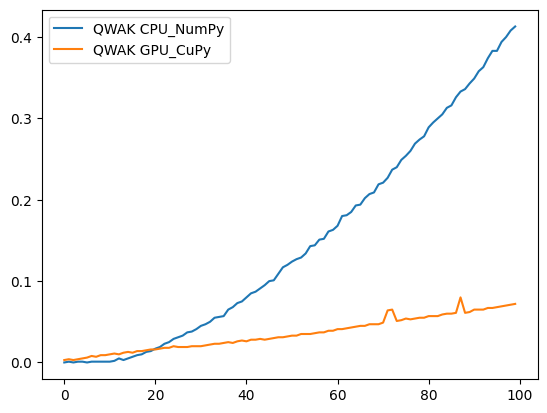

In [63]:
plt.plot(tList,label='QWAK CPU_NumPy')
plt.plot(tList_cupy,label='QWAK GPU_CuPy')
plt.legend()